In [121]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'potato-leaf-disease-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1125279%2F1888915%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240730%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240730T051217Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D47e418314fc690fc007c6f3f9bf1b41f35c82e3f8ba796b6b31b0407859f99b6c686bc48ed5201b7e8db800cb79eb7ea22d539fe2584fece36d2128ab232c533af429d8dd3160a985ed230abac1c1dc9a9d7d795d9c68d9d4f651facd17474ef997fe7e07744ece10acdf4a315fb69d10f4a0703057f439ed7627bdd5fc005687caf32b1b5619c2f6921c60c8c33b39dabaac6432114e1e6381156cc820fec5b7ff4970b863161676372ac2649521a33e26580a6d1647716307a6407da6a27a86b24d9b0d1368444881e7baf4296d9da2d007d8a10bfb814ab3cf894d32cd1cc2814d4da3bf63df3c36eadf5ebba24d119dbcc29ce0217f46d68e6d0b1f4491f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 26429932 bytes downloaded
Downloaded and uncompressed: potato-leaf-disease-dataset
Data source import complete.


# Import Libraries

In [122]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Import Data

## File path

In [123]:
train_dir = "../input/potato-leaf-disease-dataset/Potato/Train"
test_dir = "../input/potato-leaf-disease-dataset/Potato/Test"
valid_dir = "../input/potato-leaf-disease-dataset/Potato/Valid"

## Data Rescaling and augmentation

In [124]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(224, 224, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
], name ="data_augmentation")

## Load datasets

### Shuffle and prefetch

In [125]:

import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True
).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

valid_datasets = tf.keras.preprocessing.image_dataset_from_directory(
    directory = valid_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
)

class_names = valid_datasets.class_names
valid_data = valid_datasets.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 900 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [126]:
[(images, label_batch)] = train_data.take(1)
total_classes = label_batch.shape[-1]
total_classes

3

## Visualizing data

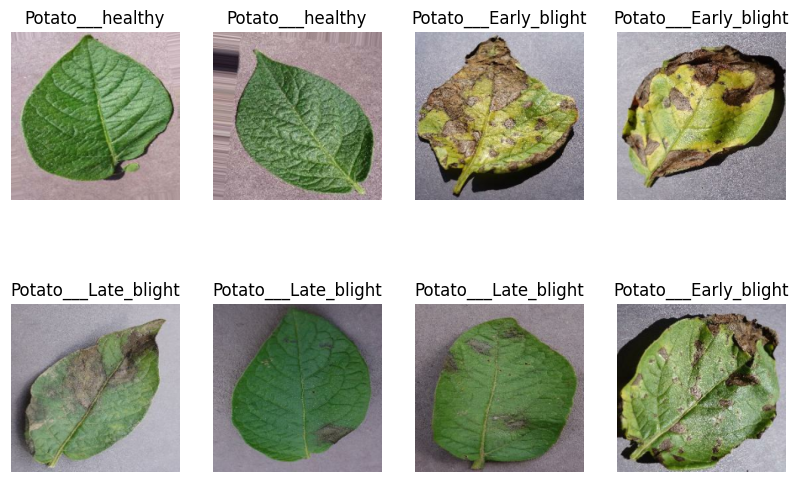

In [127]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    for i in range(0,8):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

# Create Checkpoint

In [128]:
checkpoint_path = "/CheckPoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

# Create model

In [129]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(60, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(60, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(60, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(total_classes, activation='softmax', name='output_layers')

])

In [130]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 conv2d_82 (Conv2D)          (None, None, None, 60)    1680      
                                                                 
 max_pooling2d_82 (MaxPooli  (None, None, None, 60)    0         
 ng2D)                                                           
                                                                 
 conv2d_83 (Conv2D)          (None, None, None, 60)    32460     
                                                                 
 max_pooling2d_83 (MaxPooli  (None, None, None, 60)    0         
 ng2D)                                                           
                                                     

# Compile model

In [131]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

# Fit the model

In [132]:
history = model.fit(
    train_data,
    epochs=20,
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback,
    ]
)

Epoch 1/20
29/29 [==============================] - 19s 609ms/step - loss: 1.0812 - accuracy: 0.3311 - val_loss: 1.0177 - val_accuracy: 0.6100
Epoch 2/20
29/29 [==============================] - 17s 591ms/step - loss: 0.9649 - accuracy: 0.5267 - val_loss: 0.7905 - val_accuracy: 0.7067
Epoch 3/20
29/29 [==============================] - 17s 595ms/step - loss: 0.8173 - accuracy: 0.6167 - val_loss: 0.6761 - val_accuracy: 0.6867
Epoch 4/20
29/29 [==============================] - 17s 588ms/step - loss: 0.7141 - accuracy: 0.6800 - val_loss: 0.6214 - val_accuracy: 0.7633
Epoch 5/20
29/29 [==============================] - 18s 604ms/step - loss: 0.6550 - accuracy: 0.7122 - val_loss: 0.5129 - val_accuracy: 0.7967
Epoch 6/20
29/29 [==============================] - 18s 616ms/step - loss: 0.5036 - accuracy: 0.8344 - val_loss: 0.4387 - val_accuracy: 0.8267
Epoch 7/20
29/29 [==============================] - 17s 601ms/step - loss: 0.5180 - accuracy: 0.7933 - val_loss: 0.3968 - val_accuracy: 0.9000

# Check best weight validation data percentance

In [133]:
def bestWeightModelEvaluate(model, weight_path, data):
  cp_model = tf.keras.models.clone_model(model)
  cp_model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ['accuracy']
  )
  cp_model.load_weights(weight_path)
  cp_model.evaluate(data)

In [134]:
bestWeightModelEvaluate(
    model = model,
    weight_path= checkpoint_path,
    data = valid_data
)

10/10 [==============================] - 1s 104ms/step - loss: 0.1543 - accuracy: 0.9433


In [135]:
bestWeightModelEvaluate(
    model = model,
    weight_path= checkpoint_path,
    data = test_data
)

10/10 [==============================] - 1s 101ms/step - loss: 0.1343 - accuracy: 0.9567


# Download pretrain model

In [136]:
! wget "https://github.com/HSAkash/Potato-Leaf-Disease-Dataset/raw/main/potato_pretrain_model.h5"

--2024-07-30 08:08:04--  https://github.com/HSAkash/Potato-Leaf-Disease-Dataset/raw/main/potato_pretrain_model.h5
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HSAkash/Potato-Leaf-Disease-Dataset/main/potato_pretrain_model.h5 [following]
--2024-07-30 08:08:04--  https://raw.githubusercontent.com/HSAkash/Potato-Leaf-Disease-Dataset/main/potato_pretrain_model.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 849224 (829K) [application/octet-stream]
Saving to: ‘potato_pretrain_model.h5.2’

potato_pretrain_mod 100%[===================>] 829.32K  --.-KB/s    in 0.05s   

2024-07-30 08:08:05 (15.3 

## Load model

In [137]:
load_model = tf.keras.models.load_model("potato_pretrain_model.h5")

## summary of load data

In [138]:
load_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, None, None, 60)    1680      
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 60)    0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 60)    32460     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, None, None, 60)    0         
 g2D)                                                            
                                                        

## Main model summary.
main model and load model are save

In [139]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 conv2d_82 (Conv2D)          (None, None, None, 60)    1680      
                                                                 
 max_pooling2d_82 (MaxPooli  (None, None, None, 60)    0         
 ng2D)                                                           
                                                                 
 conv2d_83 (Conv2D)          (None, None, None, 60)    32460     
                                                                 
 max_pooling2d_83 (MaxPooli  (None, None, None, 60)    0         
 ng2D)                                                           
                                                     

## Evaluate load model with valid data and test_data

In [140]:
load_model.evaluate(test_data)

10/10 [==============================] - 1s 101ms/step - loss: 0.0424 - accuracy: 0.9967


[0.042373038828372955, 0.996666669845581]

In [141]:
load_model.evaluate(valid_data)

10/10 [==============================] - 1s 102ms/step - loss: 0.0707 - accuracy: 0.9800


[0.07074113935232162, 0.9800000190734863]

## Predicting the values

In [142]:
import numpy as np
predictions = load_model.predict(test_data)
predictions = np.argmax(predictions, axis=-1)
predictions.shape

10/10 [==============================] - 1s 100ms/step


(300,)

## Visualize prediction

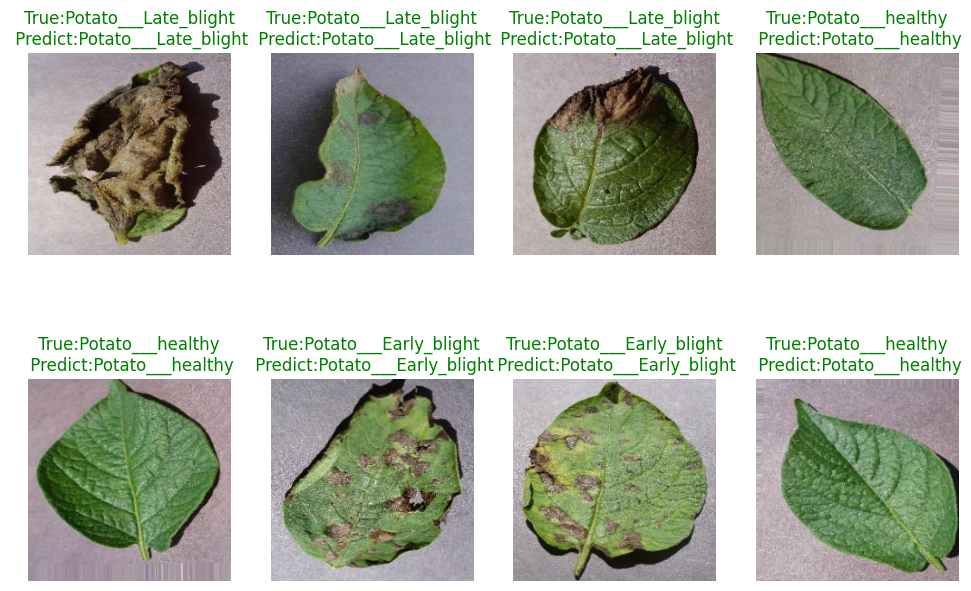

In [143]:

plt.figure(figsize=(12,12))
for image_batch,label_batch in test_data.take(1):
    for i in range(0,8):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True:{true_class}\n Predict:{predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")



In [144]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(60, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(60, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(60, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(total_classes, activation='softmax', name='output_layers')

])

In [145]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 conv2d_85 (Conv2D)          (None, None, None, 60)    1680      
                                                                 
 max_pooling2d_85 (MaxPooli  (None, None, None, 60)    0         
 ng2D)                                                           
                                                                 
 conv2d_86 (Conv2D)          (None, None, None, 60)    32460     
                                                                 
 max_pooling2d_86 (MaxPooli  (None, None, None, 60)    0         
 ng2D)                                                           
                                                     

In [146]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [147]:
history = model.fit(
    train_data,
    epochs=20,
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback,
    ]
)

Epoch 1/20
29/29 [==============================] - 19s 606ms/step - loss: 1.0914 - accuracy: 0.3267 - val_loss: 1.0488 - val_accuracy: 0.3333
Epoch 2/20
29/29 [==============================] - 17s 579ms/step - loss: 0.9640 - accuracy: 0.5067 - val_loss: 0.9102 - val_accuracy: 0.5067
Epoch 3/20
29/29 [==============================] - 17s 586ms/step - loss: 0.8532 - accuracy: 0.6167 - val_loss: 0.6806 - val_accuracy: 0.7233
Epoch 4/20
29/29 [==============================] - 17s 582ms/step - loss: 0.7220 - accuracy: 0.6744 - val_loss: 0.6508 - val_accuracy: 0.6867
Epoch 5/20
29/29 [==============================] - 17s 611ms/step - loss: 0.6652 - accuracy: 0.7178 - val_loss: 0.5274 - val_accuracy: 0.7833
Epoch 6/20
29/29 [==============================] - 17s 583ms/step - loss: 0.5857 - accuracy: 0.7444 - val_loss: 0.4498 - val_accuracy: 0.8667
Epoch 7/20
29/29 [==============================] - 17s 584ms/step - loss: 0.4485 - accuracy: 0.8256 - val_loss: 0.5482 - val_accuracy: 0.7567

In [148]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(60, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(60, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(60, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(60, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(total_classes, activation='softmax', name='output_layers')

])

In [149]:
model.summary()


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 conv2d_88 (Conv2D)          (None, None, None, 60)    1680      
                                                                 
 max_pooling2d_88 (MaxPooli  (None, None, None, 60)    0         
 ng2D)                                                           
                                                                 
 conv2d_89 (Conv2D)          (None, None, None, 60)    32460     
                                                                 
 max_pooling2d_89 (MaxPooli  (None, None, None, 60)    0         
 ng2D)                                                           
                                                     

In [150]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    epochs=100,
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback,
    ]
)

Epoch 1/100
29/29 [==============================] - 19s 604ms/step - loss: 1.0886 - accuracy: 0.3433 - val_loss: 1.0531 - val_accuracy: 0.3333
Epoch 2/100
29/29 [==============================] - 17s 583ms/step - loss: 0.9883 - accuracy: 0.4022 - val_loss: 0.8548 - val_accuracy: 0.4900
Epoch 3/100
29/29 [==============================] - 18s 611ms/step - loss: 0.8270 - accuracy: 0.6278 - val_loss: 0.6225 - val_accuracy: 0.7100
Epoch 4/100
29/29 [==============================] - 18s 615ms/step - loss: 0.6242 - accuracy: 0.6978 - val_loss: 0.5145 - val_accuracy: 0.7700
Epoch 5/100
29/29 [==============================] - 17s 582ms/step - loss: 0.5519 - accuracy: 0.7611 - val_loss: 0.4307 - val_accuracy: 0.8033
Epoch 6/100
29/29 [==============================] - 16s 569ms/step - loss: 0.4482 - accuracy: 0.7922 - val_loss: 0.3411 - val_accuracy: 0.8600
Epoch 7/100
29/29 [==============================] - 17s 602ms/step - loss: 0.4210 - accuracy: 0.8244 - val_loss: 0.7642 - val_accuracy:

In [ ]:
load_model.evaluate(test_data)

In [ ]:
load_model.evaluate(valid_data)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Function to collect true labels and predictions
def get_true_and_predicted_labels(dataset, model):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        # Predict labels
        predictions = model.predict(images)
        predicted_labels = np.argmax(predictions, axis=-1)
        true_labels = np.argmax(labels, axis=-1)

        # Append to lists
        y_true.extend(true_labels)
        y_pred.extend(predicted_labels)

    return np.array(y_true), np.array(y_pred)

# Collect true labels and predictions for the test dataset
y_true, y_pred = get_true_and_predicted_labels(test_data, load_model)


In [ ]:
# Generate classification report
class_names = valid_datasets.class_names
report = classification_report(y_true, y_pred, target_names=class_names)

print("Classification Report:")
print(report)


In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values from the history object
history_dict = history.history

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
